Questions: 
* mode=min instead of max in model checkpoints 
* test predicting all four variables instead of 1 by 1? 

Experiments: 
* one model per variable 
* one model for all variables 

This notebook: 
* loads the raw dataframe 
* split to train/val and get features and labels from the raw dataframe: 
    - split to train/val 
    - fit transformer on train, and apply on both train/val  
    - get the lookback period to the tensorflow input format 
* define one model classes and make a fit and eval function 
    - xgboost 
    - compare to observation and mtclim 
* allow using other model classes with the same eval function and compare 
    - elastic net 
    - random forest 
    - gboost 
    - LSTM x 4 as defined by Joe 
    - regular neural network 
    - attention 
    
TODO: 
* use tensorflow.keras.preprocessing.sequence import TimeseriesGenerator to generate lookback 


In [1]:
!mamba install -y numpy==1.19


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (0.8.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['numpy==1.19']

conda-forge/linux-64     [<=>                 ] (00m:00s) 
conda-forge/linux-64    

In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [11]:
import pandas as pd
import numpy as np
import fsspec
import random
import xarray as xr
from met_ml.train.features import train_test_split_based_on_lat, scale_data, get_features_and_labels
from met_ml.train.models import xgb_model

FOLDER = 's3://pangeo-scratch/cchiao/met-ml/'
random.seed(1)
random_state = 1

In [4]:
with fsspec.open(FOLDER + 'daily_data.csv') as f:
    df = pd.read_csv(f)

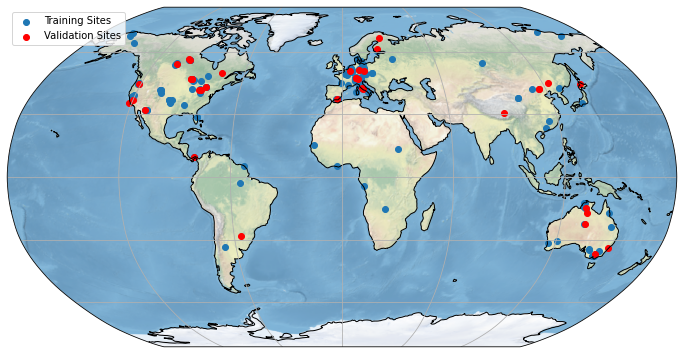

In [9]:
# get the training data 
lookback = 90

train, test = train_test_split_based_on_lat(
    data=df,
    test_size=0.2,
    random_state=random_state
)

scaled_train, scaled_test, scalers = scale_data(train, test)

X_train, Y_train = get_features_and_labels(scaled_train, lookback=lookback, input_is_2D=True)
X_test, Y_test = get_features_and_labels(scaled_test, lookback=lookback, input_is_2D=True)

# make sure the features are sorted in the same way 
assert np.all(X_train.features.values == X_test.features.values)
# make sure sample size is the same between X and Y 
assert len(X_train.samples) == len(Y_train.samples)
assert len(X_test.samples) == len(Y_test.samples)

In [ ]:
for y_var in Y_train.features.values[0:1]:
    print(y_var)
    y_train = Y_train.sel(features=y_var)
    y_test = Y_test.sel(features=y_var)
    model = xgb_model()
    model.fit(X_train, y_train, X_test, y_test)

SW_IN_F
[0]	eval-rmse:0.20886	train-rmse:0.20314
[1]	eval-rmse:0.16802	train-rmse:0.16339
[2]	eval-rmse:0.14190	train-rmse:0.13834
[3]	eval-rmse:0.12599	train-rmse:0.12245
[4]	eval-rmse:0.11685	train-rmse:0.11297
[5]	eval-rmse:0.11119	train-rmse:0.10623
[6]	eval-rmse:0.10727	train-rmse:0.10228
[7]	eval-rmse:0.10440	train-rmse:0.09892
[8]	eval-rmse:0.10216	train-rmse:0.09683
[9]	eval-rmse:0.10127	train-rmse:0.09520
[10]	eval-rmse:0.10015	train-rmse:0.09400
[11]	eval-rmse:0.09953	train-rmse:0.09318
[12]	eval-rmse:0.09915	train-rmse:0.09249
[13]	eval-rmse:0.09824	train-rmse:0.09147
[14]	eval-rmse:0.09764	train-rmse:0.09074
[15]	eval-rmse:0.09727	train-rmse:0.09021
[16]	eval-rmse:0.09712	train-rmse:0.08983
[17]	eval-rmse:0.09677	train-rmse:0.08930
[18]	eval-rmse:0.09664	train-rmse:0.08896
[19]	eval-rmse:0.09648	train-rmse:0.08861
[20]	eval-rmse:0.09621	train-rmse:0.08822
[21]	eval-rmse:0.09598	train-rmse:0.08789
[22]	eval-rmse:0.09589	train-rmse:0.08769
[23]	eval-rmse:0.09558	train-rmse:0.